In [1]:
import rasterio as rio
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import geopandas as gpd
import shapely.geometry
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import itertools
import metpy
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings('ignore')

dataDirDiscovery = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate'

In [2]:
run ../util/setupConsole

In [3]:
crop = 'Maize'
wxData = 'cpc'

yieldDataOld = False

tempYearRange = [1981, 2018]
if yieldDataOld:
    yieldYearRange = [1981, 2008]
else:
    yieldYearRange = [1981, 2013]

yearRange = np.intersect1d(np.arange(tempYearRange[0], tempYearRange[1]+1), np.arange(yieldYearRange[0], yieldYearRange[1]+1))

In [4]:
# load the sacks crop calendars

sacksMaizeStart = np.genfromtxt('%s/sacks/sacks-planting-end-Maize.txt'%dataDirDiscovery, delimiter=',')
sacksMaizeStart[sacksMaizeStart<0] = np.nan
sacksMaizeEnd = np.genfromtxt('%s/sacks/sacks-harvest-start-Maize.txt'%dataDirDiscovery, delimiter=',')
sacksMaizeEnd[sacksMaizeEnd<0] = np.nan

sacksMaizeStart = np.roll(sacksMaizeStart, int(sacksMaizeStart.shape[1]/2), axis=1)
sacksMaizeEnd = np.roll(sacksMaizeEnd, int(sacksMaizeEnd.shape[1]/2), axis=1)

sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)


In [5]:
def findConsec(data):
    # find longest consequtative sequence of years with yield data
    ptMax = (-1, -1)
    ptCur = (-1, -1)
    for i, val in enumerate(data):
        # start sequence
        if ~np.isnan(val) and ptCur[0] == -1:
            ptCur = (i, -1)
        #end sequence
        elif (np.isnan(val) and ptCur[0] >= 0):
            ptCur = (ptCur[0], i)
            if ptCur[1]-ptCur[0] > ptMax[1]-ptMax[0] or ptMax == (-1, -1):
                ptMax = ptCur
            ptCur = (-1, -1)
        # reached end of sequence
        elif i >= len(data)-1 and ptCur[0] >= 0:
            ptCur = (ptCur[0], i)
            if ptCur[1]-ptCur[0] > ptMax[1]-ptMax[0] or ptMax == (-1, -1):
                ptMax = ptCur
    return ptMax

In [6]:
# load gdd/kdd from cpc temperature data
with gzip.open('%s/kdd-%s-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, tempYearRange[0], tempYearRange[1]), 'rb') as f:
    kdd = pickle.load(f)

with gzip.open('%s/gdd-%s-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, tempYearRange[0], tempYearRange[1]), 'rb') as f:
    gdd = pickle.load(f)

with gzip.open('%s/gdd-kdd-lat-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
    tempLat = pickle.load(f)

with gzip.open('%s/gdd-kdd-lon-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
    tempLon = pickle.load(f)


In [7]:
if wxData == 'cpc':
    kdd = kdd[:,:,1:]
    gdd = gdd[:,:,1:]

In [8]:
maizeYield = []
for year in range(yieldYearRange[0],yieldYearRange[1]+1):
    
    if yieldDataOld:
        curMaizeYield = xr.open_dataset('%s/deepak/Maize_yield/Maize_areaweightedyield_%d.nc'%(dataDirDiscovery, year), decode_cf=False)
    else:
        curMaizeYield = xr.open_dataset('%s/deepak/Maize_yield_1970_2013/Maize_areaweightedyield_%d_ver12b.nc'%(dataDirDiscovery, year), decode_cf=False)
    
    curMaizeYield['time'] = [year]
    if len(maizeYield) == 0:
        maizeYield = curMaizeYield
    else:
        maizeYield = xr.concat([maizeYield, curMaizeYield], dim='time')
    
maizeYield.load()

<xarray.Dataset>
Dimensions:    (latitude: 360, level: 1, longitude: 720, time: 33)
Coordinates:
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * level      (level) float64 1.0
  * time       (time) int64 1981 1982 1983 1984 1985 ... 2010 2011 2012 2013
Data variables:
    Data       (time, level, latitude, longitude) float64 nan nan ... nan nan

In [9]:
# flip latitude axis so top is +90
if not yieldDataOld:
    latDeepak = np.flipud(maizeYield.latitude.values)
else:
    latDeepak = maizeYield.latitude.values
lonDeepak = np.roll(maizeYield.longitude.values, int(len(maizeYield.longitude)/2), axis=0)
lonDeepak[lonDeepak<0] += 360
maizeYield['Data'] = maizeYield.Data.transpose('latitude', 'longitude', 'time', 'level')
if not yieldDataOld:
    data = np.roll(np.flip(maizeYield['Data'], axis=0), int(len(lonDeepak)/2), axis=1)
else:
    data = np.roll(maizeYield['Data'], int(len(lonDeepak)/2), axis=1)

In [10]:
maizeYield['latitude'] = latDeepak
maizeYield['longitude'] = lonDeepak
maizeYield['Data'] = (('latitude', 'longitude', 'time'), np.squeeze(data))

In [11]:
kdd = kdd[:, :, 0:maizeYield.Data.shape[2]]
gdd = gdd[:, :, 0:maizeYield.Data.shape[2]]

In [12]:
with gzip.open('%s/seasonal-precip-maize-gpcp.dat'%dataDirDiscovery, 'rb') as f:
    seasonalPrecip = pickle.load(f)

In [13]:
maizeTrends = np.full([len(latDeepak), len(lonDeepak)], np.nan)

for xlat in range(len(latDeepak)):
    for ylon in range(len(lonDeepak)):
        y = np.squeeze(maizeYield.Data.values[xlat, ylon, :])
        
        if len(np.where(np.isnan(y))[0]) == 0:
            X = sm.add_constant(range(len(y)))
            mdl = sm.OLS(y, X).fit()
            maizeTrends[xlat, ylon] = mdl.params[1]
        

In [14]:
# calculate gdd and kdd trends from already-loaded cpc tmax and tmin data

if os.path.isfile('%s/kdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, tempYearRange[0], tempYearRange[1])) and os.path.isfile('%s/gdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, tempYearRange[0], tempYearRange[1])):
    with gzip.open('%s/kdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, tempYearRange[0], tempYearRange[1]), 'rb') as f:
        kddTrends = pickle.load(f)

    with gzip.open('%s/gdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, tempYearRange[0], tempYearRange[1]), 'rb') as f:
        gddTrends = pickle.load(f)
else:
    gddTrends = np.full([gdd.shape[0], gdd.shape[1]], np.nan)
    kddTrends = np.full([kdd.shape[0], kdd.shape[1]], np.nan)

    for x in range(gddTrends.shape[0]):
        for y in range(gddTrends.shape[1]):
            nn = np.where(~np.isnan(gdd[x, y, :]))[0]
            if len(nn) == gdd.shape[2]:
                X = sm.add_constant(range(gdd.shape[2]))
                mdl = sm.OLS(gdd[x, y, :], X).fit()
                gddTrends[x, y] = mdl.params[1]

            nn = np.where(~np.isnan(kdd[x, y, :]))[0]
            if len(nn) == kdd.shape[2]:
                X = sm.add_constant(range(kdd.shape[2]))
                mdl = sm.OLS(kdd[x, y, :], X).fit()
                kddTrends[x, y] = mdl.params[1]

    # if a grid cell has no gdd/kdds, trend will be exactly 0 - set to nan
    kddTrends[kddTrends == 0] = np.nan
    gddTrends[gddTrends == 0] = np.nan
    
    with gzip.open('%s/kdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, tempYearRange[0], tempYearRange[1]), 'wb') as f:
        pickle.dump(kddTrends, f)

    with gzip.open('%s/gdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, tempYearRange[0], tempYearRange[1]), 'wb') as f:
        pickle.dump(gddTrends, f)


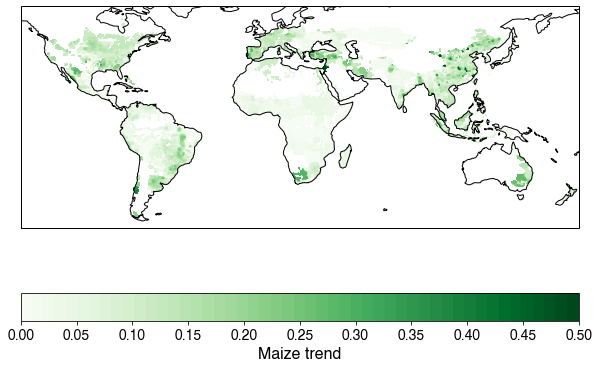

In [15]:
cRange=[0, .5]
f = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lonDeepak, latDeepak, np.clip(maizeTrends, cRange[0], cRange[1]), cmap='Greens', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .05))
cbar.set_label('Maize trend')
ax.coastlines()

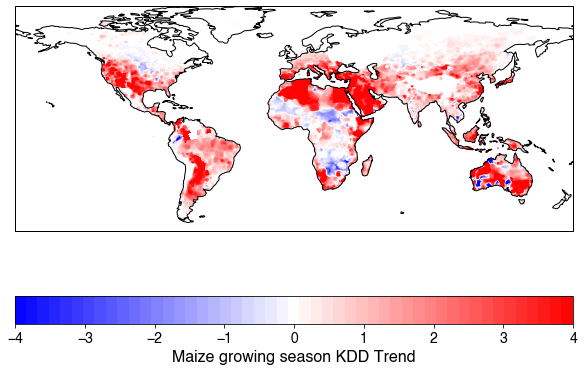

In [16]:
cRange=[-4, 4]
f = plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(tempLon, tempLat, np.clip(kddTrends, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 1))
cbar.set_label('%s growing season KDD Trend'%crop)
ax.coastlines()

In [ ]:
minCropYears = 25

yieldKddCoef = np.full([len(latDeepak), len(lonDeepak)], np.nan)
yieldGddCoef = np.full([len(latDeepak), len(lonDeepak)], np.nan)
yieldPrCoef = np.full([len(latDeepak), len(lonDeepak)], np.nan)
yieldMdlR2 = np.full([len(latDeepak), len(lonDeepak)], np.nan)

kddAgg = []
gddAgg = []
prAgg = []
yieldAgg = []

for xlat in range(yieldKddCoef.shape[0]):
    
    if xlat % 50 == 0: print('%.0f %%'%(xlat/yieldKddCoef.shape[0]*100))
        
    for ylon in range(yieldKddCoef.shape[1]):
        
        y = maizeYield.Data.values[xlat, ylon, :]
        if len(np.where(np.isnan(y))[0]) == len(y): continue
            
        ptMaxDeepak = findConsec(y)
        
        if ptMaxDeepak[1]-ptMaxDeepak[0]+1 >= minCropYears:
            # find closest temp
            indLat = np.where(abs(tempLat-latDeepak[xlat]) == np.nanmin(abs(tempLat-latDeepak[xlat])))[0]
            indLon = np.where(abs(tempLon-lonDeepak[ylon]) == np.nanmin(abs(tempLon-lonDeepak[ylon])))[0]

            k = np.nanmean(kdd[indLat, :, :], axis=0)
            k = np.nanmean(k[indLon, :], axis=0)

            g = np.nanmean(gdd[indLat, :, :], axis=0)
            g = np.nanmean(g[indLon, :], axis=0)
            
            indLatPr = np.where(abs(sacksLat-latDeepak[xlat]) == np.nanmin(abs(sacksLat-latDeepak[xlat])))[0]
            indLonPr = np.where(abs(sacksLon-lonDeepak[ylon]) == np.nanmin(abs(sacksLon-lonDeepak[ylon])))[0]
            
            p = np.nanmean(seasonalPrecip[indLatPr, :, :], axis=0)
            p = np.nanmean(p[indLonPr, :], axis=0)
            
            if len(np.where((np.isnan(k)) | (k == 0))[0]) == 0 and \
                len(np.where((np.isnan(g)) | (g == 0))[0]) == 0 and \
                len(np.where((np.isnan(p)) | (p == 0))[0]) == 0:
            
                g = scipy.signal.detrend(g[ptMaxDeepak[0]:ptMaxDeepak[1]])
                g /= np.linalg.norm(g)
                k = scipy.signal.detrend(k[ptMaxDeepak[0]:ptMaxDeepak[1]])
                k /= np.linalg.norm(k)
                p = scipy.signal.detrend(p[ptMaxDeepak[0]:ptMaxDeepak[1]])
                p /= np.linalg.norm(p)
                y = scipy.signal.detrend(y[ptMaxDeepak[0]:ptMaxDeepak[1]])
                y /= np.linalg.norm(y)

                kddAgg.extend(k)
                gddAgg.extend(g)
                prAgg.extend(p)
                yieldAgg.extend(y)

                data = {'GDD':g, \
                        'KDD':k, \
                        'Pr':p, \
                        'Yield':y}

                df = pd.DataFrame(data, \
                                  columns=['GDD', 'KDD', 'Pr', \
                                           'Yield'])
                mdl = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
                yieldGddCoef[xlat, ylon] = mdl.params['GDD']
                yieldKddCoef[xlat, ylon] = mdl.params['KDD']
                yieldPrCoef[xlat, ylon] = mdl.params['Pr']
                yieldMdlR2[xlat, ylon] = mdl.rsquared

kddAgg = np.array(kddAgg)
gddAgg = np.array(gddAgg)
prAgg = np.array(prAgg)
yieldAgg = np.array(yieldAgg)

0 %
14 %
28 %
42 %


In [ ]:
cRange=[-1, 1]
f = plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lonDeepak, latDeepak, np.clip(yieldKddCoef, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .25))
cbar.set_label('%s KDD-yield coefficient'%crop)
ax.coastlines()

In [ ]:
cRange=[-1, 1]
f = plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lonDeepak, latDeepak, np.clip(yieldGddCoef, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .25))
cbar.set_label('%s GDD-yield coefficient'%crop)
ax.coastlines()

In [ ]:
cRange=[-1, 1]
f = plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lonDeepak, latDeepak, np.clip(yieldPrCoef, cRange[0], cRange[1]), cmap='BrBG', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .25))
cbar.set_label('%s Pr-yield coefficient'%crop)
ax.coastlines()

In [ ]:
cRange=[.25, .75]
f = plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.contourf(lonDeepak, latDeepak, np.clip(yieldMdlR2, cRange[0], cRange[1]), cmap='Reds', vmin=cRange[0], vmax=cRange[1], levels=np.linspace(cRange[0], cRange[1], 50))
cbar = plt.colorbar(c, orientation='horizontal')
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, .25))
cbar.set_label('%s Yield model R2'%crop)
ax.coastlines()

In [ ]:
data = {'GDD':gddAgg, \
        'KDD':kddAgg, \
        'Pr':prAgg, \
        'Yield':yieldAgg}
                        
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', 'Pr', \
                           'Yield'])
mdl = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
mdl.summary()